In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [3]:
LOL = pd.read_csv('LeagueofLegends.csv')
matches = pd.read_csv('matchinfo.csv')
kills = pd.read_csv('kills.csv')
gold = pd.read_csv('gold.csv')
column_desc = pd.read_csv('_columns.csv')
monsters = pd.read_csv('monsters.csv')
structures = pd.read_csv('structures.csv')
bans = pd.read_csv('bans.csv')

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 50)

In [4]:
champs = [name for name in LOL.columns if 'Champ' in name]

In [5]:
list_of_dfs = [LOL, matches, kills, gold, monsters, structures, bans]

In [6]:
# only run once
LOL.golddiff = [literal_eval(array) for array in LOL.golddiff]
LOL.bKills = [literal_eval(array) for array in LOL.bKills]

In [7]:
def create_gameID(df):
    ids = []
    try:
        for i in range(len(df.Address)):
            if '=' not in df.Address[i]:
                ids.append(df.Address[i][df.Address[i].index('JP1')+3:-1])
            else:
                ids.append(df.Address[i][df.Address[i].index('Hash=')+5:-1])
        df['gameID'] = ids
    except:
        None
    return df

In [8]:
for df in list_of_dfs:
    create_gameID(df)

In [9]:
for df in list_of_dfs:
    df = df.drop('Address', axis=1, inplace=True)

### Start creating a final db
Make other table data usable and merge to matches df

#### Make kills data easier to use (no time-series)

In [22]:
column_desc.ColumnDescription[12]

" List of Blue Team's kills - [Time in minutes, Victim, Killer, Assist1, Assist2, Assist3, Assist4, x_pos, y_pos] \n"

In [10]:
bkills = kills[kills.Team == 'bKills'][kills.Time <= 15]
countbkills = bkills.fillna(0).groupby('gameID').count()

/Users/paulyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [11]:
rkills = kills[kills.Team == 'rKills'][kills.Time <= 15]
countrkills = rkills.fillna(0).groupby('gameID').count()

/Users/paulyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [12]:
countbkills['totassists'] = countbkills.Assist_1 + countbkills.Assist_2 + countbkills.Assist_3 + countbkills.Assist_4
countrkills['totassists'] = countrkills.Assist_1 + countrkills.Assist_2 + countrkills.Assist_3 + countrkills.Assist_4


add these to a final df

In [13]:
final = matches.merge(bkills.groupby('gameID')[['Killer']].count(), on='gameID', how='left').rename(columns={'Killer':'bkills'})

final = final.merge(countbkills[['totassists']], on='gameID').rename(columns={'totassists':'b_assists'})

final = final.merge(countrkills[['Killer']], on='gameID').rename(columns={'Killer':'rkills'})

final = final.merge(countrkills[['totassists']], on='gameID').rename(columns={'totassists':'r_assists'})

#### Make monsters data easier to use

In [30]:
set(monsters.Team)

{'bBarons', 'bDragons', 'bHeralds', 'rBarons', 'rDragons', 'rHeralds'}

In [31]:
set(monsters.Type)

{'AIR_DRAGON',
 'BARON_NASHOR',
 'DRAGON',
 'EARTH_DRAGON',
 'ELDER_DRAGON',
 'FIRE_DRAGON',
 'RIFT_HERALD',
 'WATER_DRAGON'}

In [14]:
monsters = monsters[monsters.Time <=15]

In [15]:
bdrags = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bDragons', level='Team').rename(columns={'Type':'bdragons'})
# bbars = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bBarons', level='Team').rename(columns={'Type':'bbarons'})
bhers = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bHeralds', level='Team').rename(columns={'Type':'bheralds'})


In [16]:
rdrags = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rDragons', level='Team').rename(columns={'Type':'rdragons'})
# rbars = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rBarons', level='Team').rename(columns={'Type':'rbarons'})
rhers = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rHeralds', level='Team').rename(columns={'Type':'rheralds'})


add to final df

In [17]:
final = final.merge(bdrags, on='gameID',how='left').merge(bhers, on='gameID',how='left')
final = final.merge(rdrags, on='gameID',how='left').merge(rhers, on='gameID',how='left')

final = final.fillna(0)

#### Make gold data easier to use
Domain knowledge: gold differential is very important in any matchup <br>
Gold amounts for each position is very player specific, and may not really be good features to include

In [37]:
column_desc.ColumnDescription[10]

' Gold difference - computed Blue minus Red - by minute \n'

In [19]:
gold15min = gold[gold.Type == 'golddiff'][['gameID','min_15']].groupby('gameID').sum()

gold15min = gold15min.rename(columns={'min_15':'gold_15_min'})

final = final.merge(gold15min, on='gameID', how='left')

#### Make structures data easier to use

In [23]:
grp_struct = structures[structures.Time <= 15].groupby(['gameID','Team','Lane']).count()[['Type']]

In [24]:
bot_structs = grp_struct.unstack().unstack()['Type']['BOT_LANE']

bot_structs.columns = [col + '_bot' for col in bot_structs.columns]

bot_structs = bot_structs.fillna(0)

bot_structs = bot_structs.reset_index()

In [25]:
mid_structs = grp_struct.unstack().unstack()['Type']['MID_LANE']

mid_structs.columns = [col + '_mid' for col in mid_structs.columns]

mid_structs = mid_structs.fillna(0)

mid_structs = mid_structs.reset_index()

In [26]:
top_structs = grp_struct.unstack().unstack()['Type']['TOP_LANE']

top_structs.columns = [col + '_top' for col in top_structs.columns]

top_structs = top_structs.fillna(0)

top_structs = top_structs.reset_index()

In [27]:
final = final.merge(top_structs, on='gameID', how='left').merge(mid_structs, on='gameID', how='left').merge(bot_structs, on='gameID', how='left')

#### Make each champ a dummy variable

In [29]:
all_champs = []
for col in champs:
    all_champs.extend(list(matches[f'{col}'].unique()))

In [30]:
dummies = []

for idx, row in matches[champs].iterrows():
    new = {}
    for champ in all_champs:
        new[champ] = 0
    for played in row:
        if played in all_champs:
            new[played] += 1
        else:
            continue
    dummies.append(new)

In [31]:
champsdf = pd.DataFrame(dummies)

In [32]:
champsdf.rename(columns={'MonkeyKing':'Wukong'},inplace=True)

add to final df

In [33]:
final = pd.concat([final,champsdf], axis=1)

# Remove some features

In [34]:
cols_to_drop = list(final.columns[:29])

In [35]:
cols_to_drop.remove('bResult')

In [36]:
final = final.drop(cols_to_drop, axis=1)

In [37]:
final.fillna(0,inplace=True)

### More EDA for further feature selection

In [38]:
import seaborn as sns

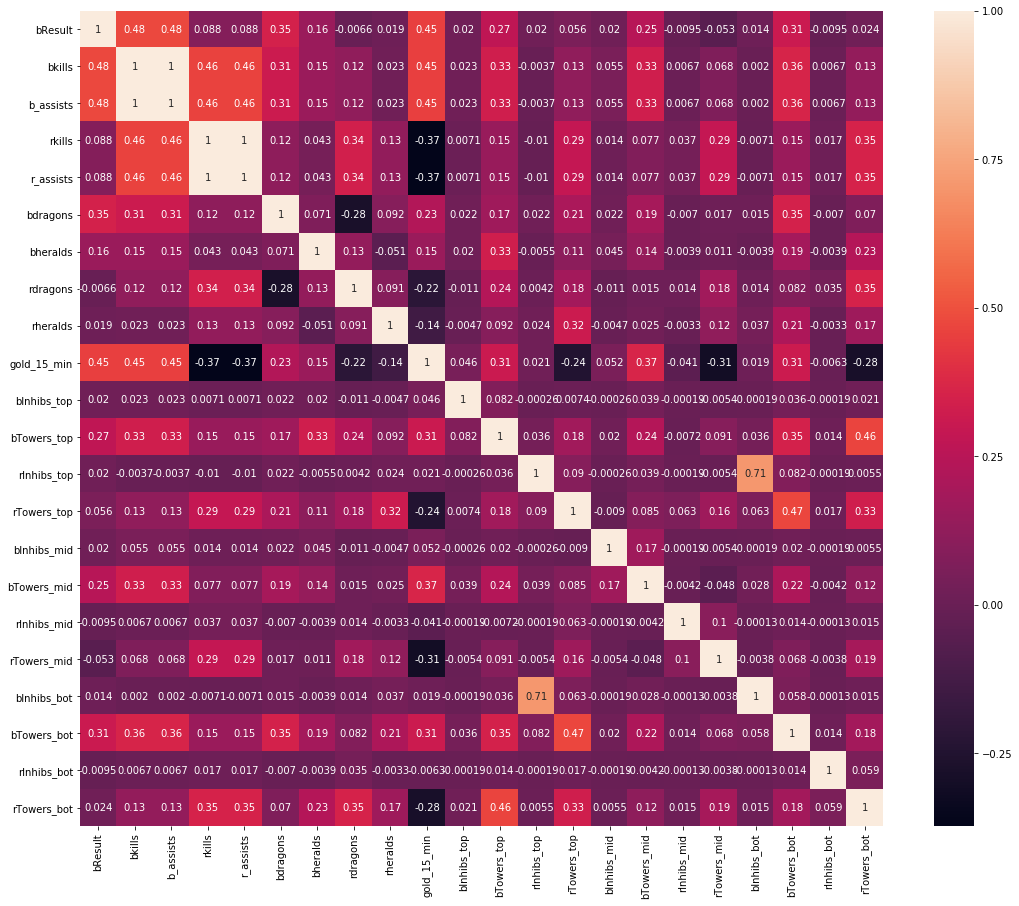

In [39]:
fig1, ax1 = plt.subplots(figsize=(18,15))

sns.heatmap(final[final.columns[:23]].corr(), annot=True)

In [40]:
# getting rid of highly correlated features
final2 = final.drop(['b_assists', 'r_assists'],axis=1)

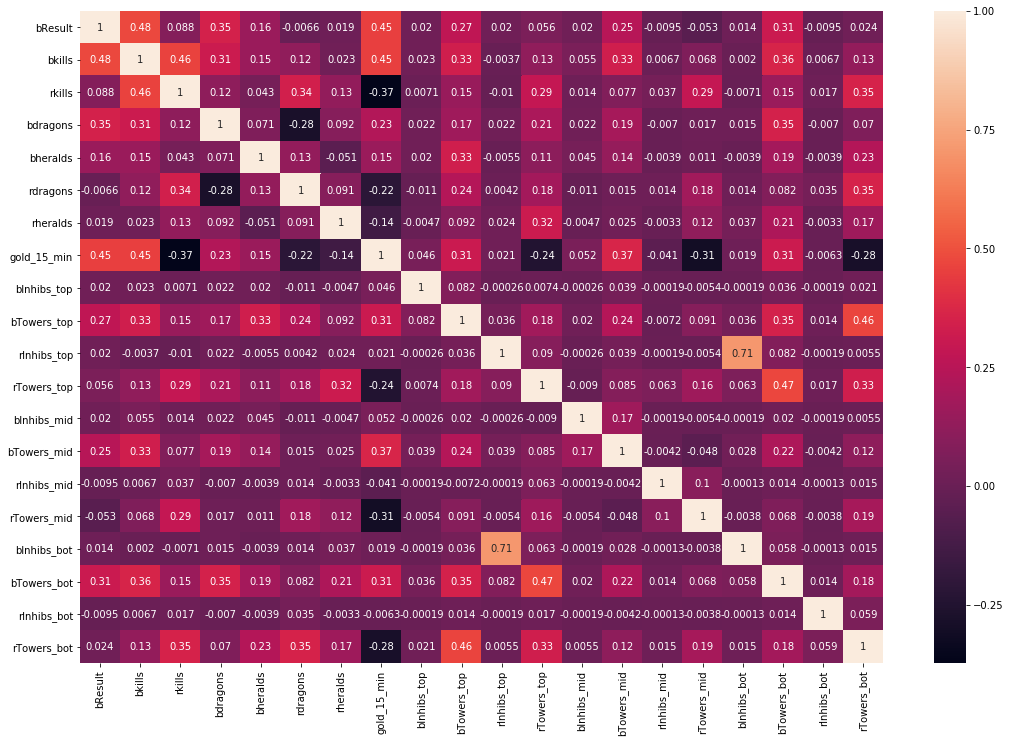

In [41]:
fig1, ax2 = plt.subplots(figsize=(18,12))

sns.heatmap(final2[final2.columns[:21]].corr(),annot=True)

### Modelling

In [42]:
features = final2.columns[2:]

X = final2.loc[:,features]
y = final2.loc[:,'bResult']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

### Principal Component Analysis (PCA)

In [68]:
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from mpl_toolkits.mplot3d import Axes3D

##### Normalize data for PCA

In [47]:
stdX = StandardScaler().fit_transform(X)
normalized_df = pd.DataFrame(data=stdX, columns=X.columns)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [48]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(stdX)

In [49]:
pcdf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3'])
pcaresults = pd.concat([pcdf, y], axis=1)

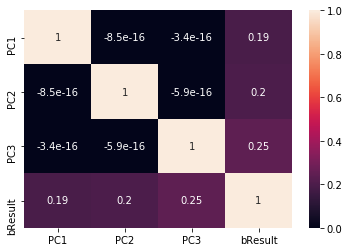

In [50]:
sns.heatmap(pcaresults.corr(),annot=True)

<IPython.core.display.Javascript object>


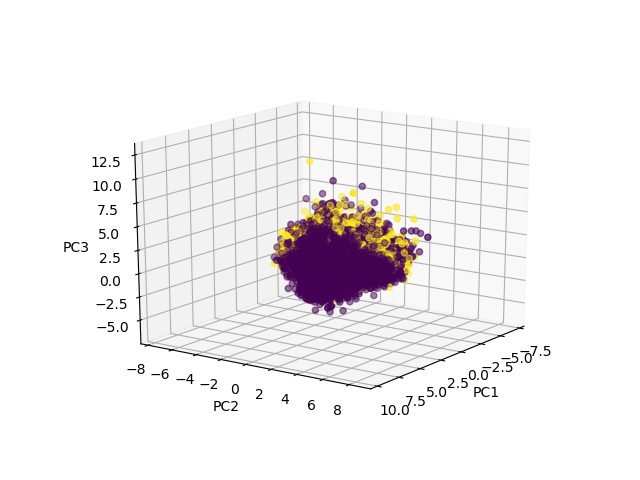

Text(0.5, 0, 'PC3')

In [51]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pcaresults.PC1, pcaresults.PC2, pcaresults.PC3, c=pcaresults.bResult)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

### SVM?

In [54]:
X2 = pcaresults[['PC1', 'PC2', 'PC3']]

In [55]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,random_state=42)

In [56]:
svm1 = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=.5, loss='hinge'))
])

In [57]:
svm1.fit(X2_train,y_train)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [63]:
svm1.score(X2_train,y_train)

0.6430446194225722

In [66]:
svm1.fit(X2_test,y_test)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [67]:
svm1.score(X2_test,y_test)

0.6176727909011374

In [62]:
svm1_pred = svm1.predict(X2_test)

In [65]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=svm1_pred))

,0,1
0,934,433
1,418,501


##### svm2

In [73]:
svm2 = SVC()

In [74]:
svm2.fit(X2_train, y_train)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [75]:
svm2.score(X2_train, y_train)

0.6734158230221222

In [77]:
svm2.predict(X2_test)

array([1., 1., 1., ..., 1., 1., 0.])

##### svm3

In [78]:
svm3 = SVC(kernel='poly', degree=4, C=.5)

In [79]:
svm3.fit(X2_train, y_train)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [80]:
svm3.score(X2_train, y_train)

0.5948631421072366